# Results plotting

Change file_path below to the .pkl saved by main.py and run all cells. The notebook will inspect which keys exist and plot available diagnostics (losses, calibration, sharpness, ECE, group cali scores, scoring rules).

In [3]:
# Imports and load results
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

# Set this to the .pkl file produced by main.py
file_path = "boston_lossscaled_batch_cal_ens1_bootFalse_seed0.pkl"

with open(file_path, "rb") as f:
    results = pickle.load(f)

print("Loaded keys:", sorted(list(results.keys())))

Loaded keys: ['args', 'best_model', 'best_sharp_score', 'model', 'recal_exp_props', 'recal_model', 'recal_te_cali_score', 'recal_te_cali_score_best', 'recal_te_g_cali_scores', 'recal_te_g_cali_scores_best', 'recal_te_obs_props', 'recal_te_obs_props_best', 'recal_te_q_preds', 'recal_te_q_preds_best', 'recal_te_scoring_rules', 'recal_te_scoring_rules_best', 'recal_te_sharp_score', 'recal_te_sharp_score_best', 'recal_va_cali_score', 'recal_va_cali_score_best', 'recal_va_g_cali_scores', 'recal_va_g_cali_scores_best', 'recal_va_obs_props', 'recal_va_obs_props_best', 'recal_va_q_preds', 'recal_va_q_preds_best', 'recal_va_scoring_rules', 'recal_va_scoring_rules_best', 'recal_va_sharp_score', 'recal_va_sharp_score_best', 'te_cali_score', 'te_cali_score_best', 'te_exp_props', 'te_exp_props_best', 'te_g_cali_scores', 'te_g_cali_scores_best', 'te_loss_list', 'te_obs_props', 'te_obs_props_best', 'te_q_preds', 'te_q_preds_best', 'te_scoring_rules', 'te_scoring_rules_best', 'te_sharp_score', 'te_sha

In [4]:
# Quick summary helper
def maybe_get(key, default=None):
    return results.get(key, default)

def to_np(x):
    if x is None:
        return None
    if isinstance(x, list):
        try:
            return np.array(x)
        except Exception:
            return np.array([np.array(i) for i in x])
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    return np.array(x)

for key in [
    'tr_loss_list','va_loss_list','te_loss_list','va_sharp_list','va_ece_list',
    'va_exp_props','va_obs_props','va_q_preds','te_exp_props','te_obs_props','te_q_preds',
    'te_g_cali_scores','te_scoring_rules'
]:
    if key in results:
        val = results[key]
        print(f"{key}: type={type(val)}, shape_example=", getattr(val, '__len__', lambda:None)())
    else:
        print(f"{key}: MISSING")

tr_loss_list: type=<class 'list'>, shape_example= 30
va_loss_list: type=<class 'list'>, shape_example= 30
te_loss_list: type=<class 'list'>, shape_example= 30
va_sharp_list: type=<class 'list'>, shape_example= 30
va_ece_list: type=<class 'list'>, shape_example= 30
va_exp_props: type=<class 'torch.Tensor'>, shape_example= 501
va_obs_props: type=<class 'torch.Tensor'>, shape_example= 501
va_q_preds: type=<class 'torch.Tensor'>, shape_example= 91
te_exp_props: type=<class 'torch.Tensor'>, shape_example= 99
te_obs_props: type=<class 'torch.Tensor'>, shape_example= 99
te_q_preds: type=<class 'torch.Tensor'>, shape_example= 51
te_g_cali_scores: type=<class 'numpy.ndarray'>, shape_example= 10
te_scoring_rules: type=<class 'dict'>, shape_example= 5


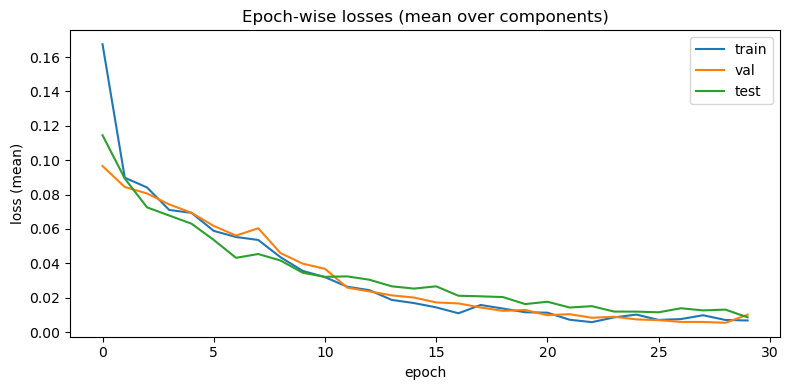

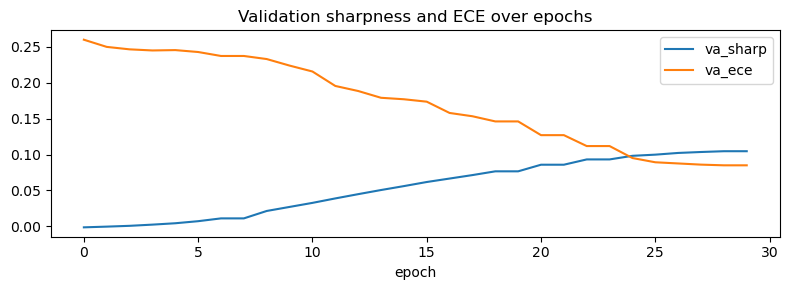

In [5]:
# Plot epoch-wise losses and optional validation diagnostics
tr = to_np(maybe_get('tr_loss_list'))
va = to_np(maybe_get('va_loss_list'))
te = to_np(maybe_get('te_loss_list'))

plt.figure(figsize=(8,4))
if tr is not None:
    # tr may be array of vectors per epoch; try to reduce to scalar if needed
    try:
        tr_mean = np.array([np.mean(x) for x in tr])
    except Exception:
        tr_mean = np.array(tr)
    plt.plot(tr_mean, label='train')
if va is not None:
    try:
        va_mean = np.array([np.mean(x) for x in va])
    except Exception:
        va_mean = np.array(va)
    plt.plot(va_mean, label='val')
if te is not None:
    try:
        te_mean = np.array([np.mean(x) for x in te])
    except Exception:
        te_mean = np.array(te)
    plt.plot(te_mean, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (mean)')
plt.legend()
plt.title('Epoch-wise losses (mean over components)')
plt.tight_layout()
plt.show()

# Plot va_sharp_list and va_ece_list if present
va_sharp = to_np(maybe_get('va_sharp_list'))
va_ece = to_np(maybe_get('va_ece_list'))
if va_sharp is not None or va_ece is not None:
    plt.figure(figsize=(8,3))
    if va_sharp is not None:
        plt.plot(va_sharp, label='va_sharp')
    if va_ece is not None:
        plt.plot(va_ece, label='va_ece')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Validation sharpness and ECE over epochs')
    plt.tight_layout()
    plt.show()

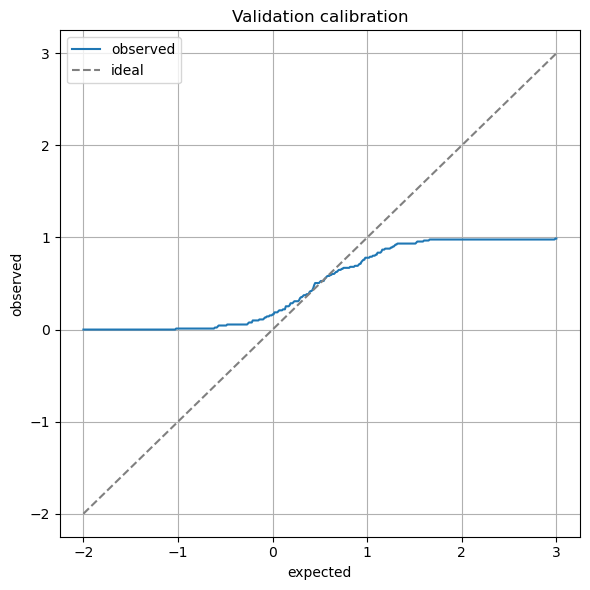

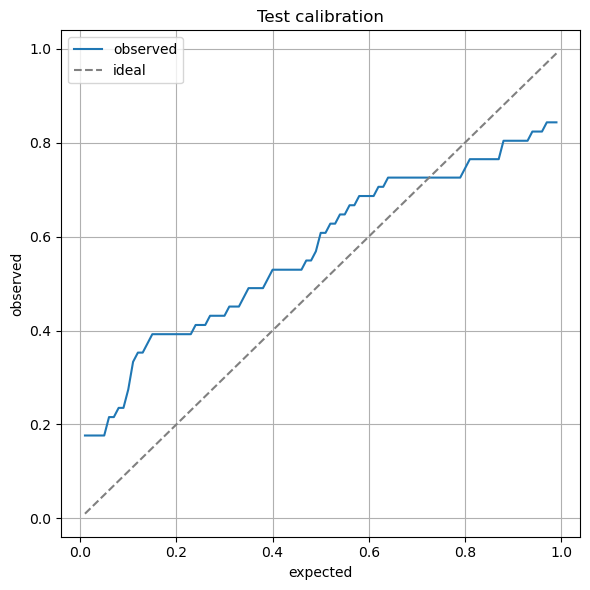

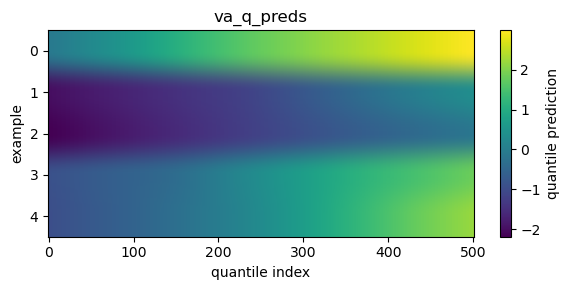

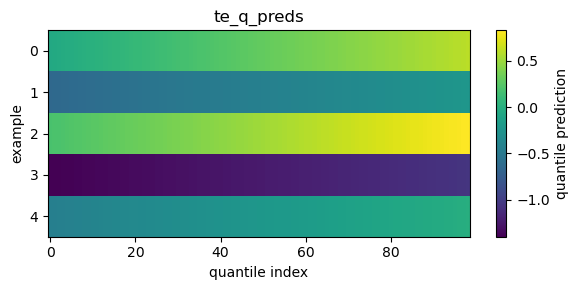

In [6]:
# Calibration curves and quantile predictions
def plot_cali(exp_props, obs_props, title='Calibration curve'):
    exp = to_np(exp_props)
    obs = to_np(obs_props)
    if exp is None or obs is None:
        print('Missing exp_props or obs_props')
        return
    plt.figure(figsize=(6,6))
    plt.plot(exp, obs, label='observed')
    plt.plot(exp, exp, '--', color='gray', label='ideal')
    plt.xlabel('expected')
    plt.ylabel('observed')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

va_exp = maybe_get('va_exp_props')
va_obs = maybe_get('va_obs_props')
if va_exp is not None and va_obs is not None:
    plot_cali(va_exp, va_obs, title='Validation calibration')
else:
    print('Validation calibration data missing')

te_exp = maybe_get('te_exp_props')
te_obs = maybe_get('te_obs_props')
if te_exp is not None and te_obs is not None:
    plot_cali(te_exp, te_obs, title='Test calibration')
else:
    print('Test calibration data missing')

# If q-pred matrices exist, show a heatmap-like summary for a few examples
va_q = maybe_get('va_q_preds')
te_q = maybe_get('te_q_preds')
import numpy as _np
def show_q_matrix(qm, name='q_preds', n_examples=5):
    if qm is None:
        print(f"{name} missing")
        return
    qm_np = to_np(qm)
    # qm expected shape (n_examples, n_quantiles)
    n = min(n_examples, qm_np.shape[0])
    plt.figure(figsize=(6, n*0.6))
    plt.imshow(qm_np[:n, :], aspect='auto', cmap='viridis')
    plt.colorbar(label='quantile prediction')
    plt.ylabel('example')
    plt.xlabel('quantile index')
    plt.title(name)
    plt.tight_layout()
    plt.show()

show_q_matrix(va_q, 'va_q_preds')
show_q_matrix(te_q, 'te_q_preds')

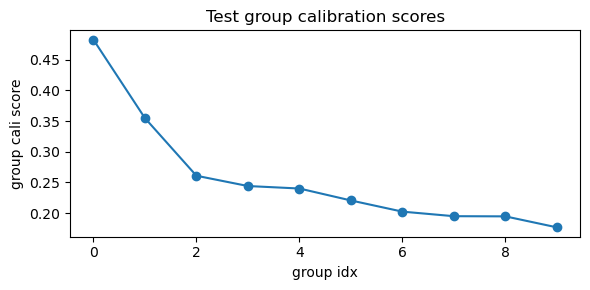


Test scoring rules (summary):
type: <class 'dict'> shape: ()
Could not summarize te_scoring_rules: unsupported operand type(s) for /: 'dict' and 'int'


In [7]:
# Group calibration scores and scoring rules
te_g = to_np(maybe_get('te_g_cali_scores'))
te_scores = maybe_get('te_scoring_rules')
if te_g is not None:
    te_g = np.array(te_g)
    plt.figure(figsize=(6,3))
    plt.plot(te_g, marker='o')
    plt.xlabel('group idx')
    plt.ylabel('group cali score')
    plt.title('Test group calibration scores')
    plt.tight_layout()
    plt.show()
else:
    print('te_g_cali_scores missing')

if te_scores is not None:
    print('\nTest scoring rules (summary):')
    try:
        # Attempt to coerce to numpy and print basic stats
        s = to_np(te_scores)
        print('type:', type(te_scores), 'shape:', getattr(s, 'shape', None))
        if s is not None and s.size > 0:
            print('min,mean,max:', s.min(), s.mean(), s.max())
    except Exception as e:
        print('Could not summarize te_scoring_rules:', e)
else:
    print('te_scoring_rules missing')

In [12]:
# Scalar-only comparison: print orig vs best (no plots)
def get_np(key):
    v = maybe_get(key)
    return to_np(v) if v is not None else None

def print_scalar_cmp(k, kb=None):
    kb = kb or k + '_best'
    a = get_np(k); b = get_np(kb)
    if a is None and b is None:
        print(f'{k} / {kb}: MISSING')
        return
    print('\n' + '-'*40)
    print(f'Compare {k} vs {kb}')
    # Scalars
    if a is not None and (np.isscalar(a) or getattr(a, 'shape', ()) == ()):
        try: print(f'  orig = {float(a):.6g}')
        except: print(f'  orig = {a}')
    else:
        if a is not None:
            try: print('  orig stats min,mean,max:', np.min(a), np.mean(a), np.max(a))
            except: print('  orig = (non-scalar, could not summarize)')

    if b is not None and (np.isscalar(b) or getattr(b, 'shape', ()) == ()):
        try: print(f'  best = {float(b):.6g}')
        except: print(f'  best = {b}')
    else:
        if b is not None:
            try: print('  best stats min,mean,max:', np.min(b), np.mean(b), np.max(b))
            except: print('  best = (non-scalar, could not summarize)')

scalar_pairs = [
    ('te_cali_score','te_cali_score_best'),
    ('te_sharp_score','te_sharp_score_best'),
    ('va_cali_score','va_cali_score_best'),
    ('va_sharp_score','va_sharp_score_best'),
    ('recal_te_cali_score','recal_te_cali_score_best'),
    ('recal_te_sharp_score','recal_te_sharp_score_best'),
]

for k,kb in scalar_pairs:
    print_scalar_cmp(k,kb)

print('\nScalar comparison complete.')


----------------------------------------
Compare te_cali_score vs te_cali_score_best
  orig = 0.114664
  best = 0.104579

----------------------------------------
Compare te_sharp_score vs te_sharp_score_best
  orig = 0.102854
  best = 0.096556

----------------------------------------
Compare va_cali_score vs va_cali_score_best
  orig = 0.0836769
  best = 0.0935961

----------------------------------------
Compare va_sharp_score vs va_sharp_score_best
  orig = 0.104604
  best = 0.0981818

----------------------------------------
Compare recal_te_cali_score vs recal_te_cali_score_best
  orig = 0.0689087
  best = 0.0646386

----------------------------------------
Compare recal_te_sharp_score vs recal_te_sharp_score_best
  orig = 0.264087
  best = 0.259779

Scalar comparison complete.
